# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with the Reacher environment.

### 1. Import the Necessary Packages

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

### 2. Instantiate the Environment and Agent

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment for training
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

/Users/benhosken/training/udacity/deep_rl_nanodegree/deep-reinforcement-learning/p2_continuous-control/ddpg_agent.py:117: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 1	Average Score: 0.70	Score: 0.70 New best
Episode 8	Average Score: 0.83	Score: 2.22 New best
Episode 9	Average Score: 1.08	Score: 3.03 New best
Episode 12	Average Score: 1.14	Score: 2.46 New best
Episode 13	Average Score: 1.24	Score: 2.35 New best
Episode 14	Average Score: 1.42	Score: 3.78 New best
Episode 16	Average Score: 1.65	Score: 5.20 New best
Episode 17	Average Score: 1.68	Score: 2.07 New best
Episode 18	Average Score: 1.72	Score: 2.49 New best
Episode 19	Average Score: 1.76	Score: 2.47 New best
Episode 20	Average Score: 1.88	Score: 4.17 New best
Episode 21	Average Score: 1.96	Score: 3.55 New best
Episode 22	Average Score: 1.98	Score: 2.36 New best
Episode 23	Average Score: 2.06	Score: 3.75 New best
Episode 24	Average Score: 2.11	Score: 3.33 New best
Episode 25	Average Score: 2.23	Score: 4.99 New best
Episode 26	Average Score: 2.38	Score: 6.15 New best
Episode 27	Average Score: 2.41	Score: 3.28 New best
Episode 28	Average Score: 2.55	Score: 6.23 New best
Episode 29	Aver

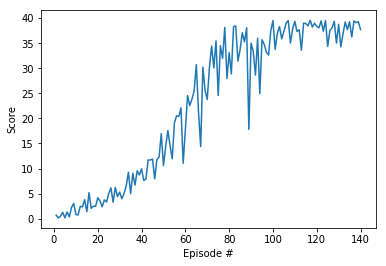

In [3]:
def ddpg(n_episodes=500, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations 

        agent.reset()
        agent_scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states, add_noise=False)         # select an action (preclipped)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent_scores += env_info.rewards                         # update the score (for each agent)
            
            agent.step(states, actions, rewards, next_states, dones, t)
            
            states = next_states                               # roll over states to next time step

            if np.any(dones):
                break 

        mean_score = np.mean(agent_scores) # calculate the mean score across the agents
        scores_deque.append(mean_score)
        scores.append(mean_score)
        average_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, average_score, mean_score), end="")
        if average_score > max_score:
            print(" New best")
            max_score = average_score
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score)) 
        if average_score > 30:
            print('\nEpisode {}: Avg. Score {:.2f} > 30.'.format(i_episode, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break # as we have solvced it            
    return scores


# reload the best weights so far
# agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
# agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))


scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch the trained Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [4]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the scores (for each agent)
while True:
    actions = agent.act(states)                         # select an action (preclipped)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 14.98999966494739


In [5]:
env.close()